# Comparison
This notebook will take the calculated SHAP-values and the dataset. Based on the SHAP-values, the most important features will be selected. We will then compare the average G3 grade of the students by applying a filter for the important features (e.g. students with <2 absences and those with >=2 absences). We will then calculate the average G3 grade for both groups and compare them using a t-test to see if the difference is statistically significant. 

By doing this, we can come up with advice for students on how to improve their grades.

In [34]:
import numpy as np
import pandas as pd

In [35]:
# Read the data
maths = pd.read_csv("data/Maths.csv")
portugese = pd.read_csv("data/Portuguese.csv")

# Combine the two datasets
data = pd.concat([maths, portugese])

# Read the SHAP values
shap_values = pd.read_csv("results.csv")

# Normalize the SHAP values so that they sum to 1 per row. Also use absolute values.
names = shap_values.iloc[:, 0]
numeric_data = shap_values.iloc[:, 1:]
numeric_data = numeric_data.abs()
normalized_data = numeric_data.div(numeric_data.sum(axis=1), axis=0)
shap_values = pd.concat([names, normalized_data], axis=1)

# Split setup into three columns, split by "/"
shap_values[["Course", "Prediction type", "Experiment setup"]] = shap_values["Setup"].str.split("/", expand=True)

shap_values.head()


,Setup,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,G1,G2,Course,Prediction type,Experiment setup
0,Math/Binary/A,0.069024,0.003860,0.020780,0.021368,0.002704,0.131075,0.018134,0.042126,0.026291,...,0.003136,0.006176,0.026839,0.003016,0.001008,0.093396,0.278427,Math,Binary,A
1,Portugese/Binary/A,0.088529,0.000828,0.033998,0.020814,0.001016,0.033581,0.066963,0.012228,0.028780,...,0.001782,0.002745,0.027090,0.014752,0.006986,0.110664,0.049311,Portugese,Binary,A
2,Math/Binary/B,0.093496,0.017426,0.016830,0.012027,0.004601,0.122190,0.001367,0.052013,0.026773,...,0.007571,0.005298,0.000616,0.007680,0.015893,0.242301,0.000000,Math,Binary,B
3,Portugese/Binary/B,0.049389,0.034969,0.030801,0.041139,0.050732,0.147560,0.053099,0.021522,0.003940,...,0.018369,0.020341,0.085143,0.009483,0.010487,0.084904,0.000000,Portugese,Binary,B
4,Portugese/Binary/C,0.044217,0.053245,0.022359,0.057568,0.049941,0.120938,0.039288,0.022166,0.018022,...,0.017709,0.022750,0.062574,0.011689,0.016126,0.000000,0.000000,Portugese,Binary,C


# Average standard deviation
To see if different models find the same important features, we will calculate the average standard deviation of the SHAP-values for each feature. If the average standard deviation is low, we see that all models agree on the importance of the feature. If the average standard deviation is high, we see that the models disagree on the importance of the feature.

We must note that the SHAP-values for G1 and G2 are 0 for models that do not use these features. In these cases, we exclude the rows where they are 0 from the calculation of the average and standard deviation.

In [36]:
# For each column (expect the setup name columns), calculate the mean SHAP value and the standard deviation and print it
shap_values_avg = {}
for column in shap_values.columns[1:-3]:
    shap_values_avg[column] = {}

    # Exclude 0-values for G1 and G2 (because they are not used in the model)
    if column in ["G1", "G2"]:
        shap_values_avg[column]["avg"] = shap_values[shap_values[column] != 0][column].mean()
        shap_values_avg[column]["std"] = shap_values[shap_values[column] != 0][column].std()
    else:
        shap_values_avg[column]["avg"] = shap_values[column].mean()
        shap_values_avg[column]["std"] = shap_values[column].std()

# Order by average SHAP value before printing
shap_values_avg = {key: value for key, value in sorted(shap_values_avg.items(), key=lambda item: item[1]["avg"], reverse=True)}
for column in shap_values_avg:
    print(f"{column}: {shap_values_avg[column]['avg']} +/- {shap_values_avg[column]['std']}")

# Print average standard deviation for all setups combined
avg_std = np.mean([shap_values_avg[column]["std"] for column in shap_values.columns[1:-3]])
print(f"The average standard deviation is {avg_std}")


G2: 0.20163069066890035 +/- 0.12019813179400625
G1: 0.13975408501128553 +/- 0.12291084520818002
failures: 0.1045826435496951 +/- 0.10495680611006138
absences: 0.07886957989668228 +/- 0.08000729903821362
age: 0.05509473450643008 +/- 0.041050822330502834
freetime: 0.03314338357204017 +/- 0.029060825314933977
Medu: 0.02842204473413712 +/- 0.022975034010421776
higher_yes: 0.02817949215873684 +/- 0.032150927966379535
famrel: 0.026236680730043677 +/- 0.026208058410680087
Dalc: 0.02586998336146125 +/- 0.04043864633659654
traveltime: 0.025272500127587638 +/- 0.02348245545949017
goout: 0.025147231663798657 +/- 0.021465961863205166
school_MS: 0.023687548005078305 +/- 0.02547941651872839
Fedu: 0.023425602891929746 +/- 0.01718657981253667
Walc: 0.023363921210357713 +/- 0.020462217962178095
health: 0.020645961828504266 +/- 0.0134004582324558
studytime: 0.019893469537853814 +/- 0.01988935476305075
paid_yes: 0.019044839298371877 +/- 0.017474804899100686
romantic_yes: 0.01841039799868147 +/- 0.0260700

# Important features and their impact on the G3 grade
We will calculate the average G3 grade based on all students and then filter the students based on the important features. We consider a feature to be important if the average SHAP-value is higher than 0.05 (5%). 

For each of these features we will set the threshold to different values in the dataset and calculate the average G3 grade for the students that meet the threshold and those that do not. We will then compare the average G3 grade for both groups using a t-test to see if the difference is statistically significant.

By doing this, we can come up with conclusions on when a student should meet a certain threshold to improve their grades.

G2 >= 4: 11.54669260700389 vs G2 < 4: 0.0 (p-value: 3.0959446446392704e-43, significant: True)
G2 >= 5: 11.557935735150926 vs G2 < 5: 0.0 (p-value: 1.4387794667421668e-45, significant: True)
G2 >= 6: 11.712301587301587 vs G2 < 6: 1.6 (p-value: 2.2204865717363116e-67, significant: True)
G2 >= 7: 11.854969574036511 vs G2 < 7: 2.9193548387096775 (p-value: 8.808823436893096e-82, significant: True)
G2 >= 8: 12.08113804004215 vs G2 < 8: 4.090909090909091 (p-value: 8.378110260660868e-105, significant: True)
G2 >= 9: 12.436716077537058 vs G2 < 9: 5.631578947368421 (p-value: 2.5954124096869497e-126, significant: True)
G2 >= 10: 12.986754966887418 vs G2 < 10: 7.047781569965871 (p-value: 1.022267057939195e-147, significant: True)
G2 >= 11: 13.575079872204473 vs G2 < 11: 7.990521327014218 (p-value: 1.9863724558668515e-159, significant: True)
G2 >= 12: 14.268993839835728 vs G2 < 12: 8.771836007130124 (p-value: 6.67993594410918e-160, significant: True)
G2 >= 13: 14.919220055710307 vs G2 < 13: 9.4542

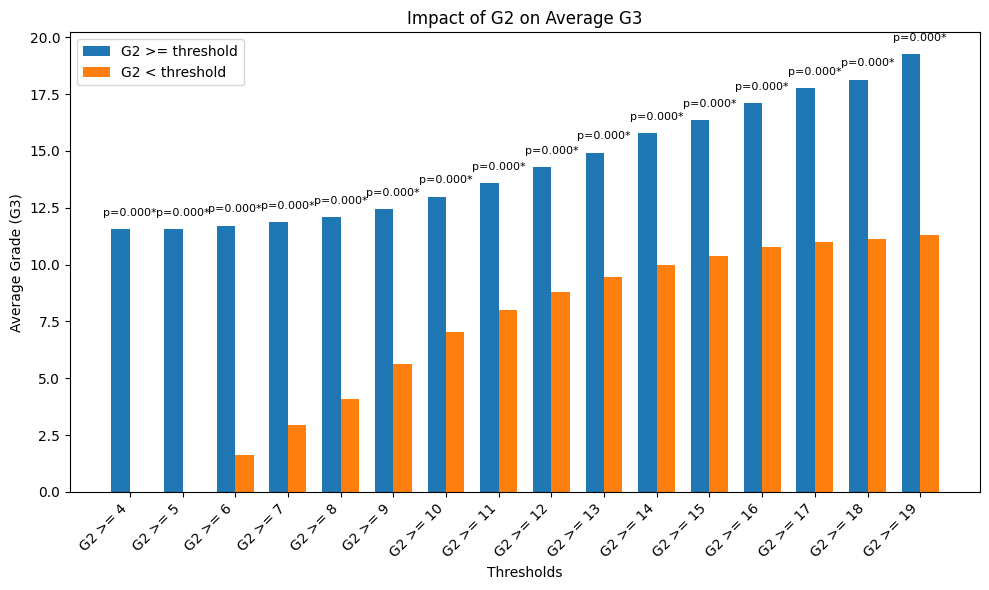

d:\Bestanden\Documenten\GitHub\SHAP-analysis-for-student-advice\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


G1 >= 3: 11.32695984703633 vs G1 < 3: 11.0 (p-value: 0.9052192065128076, significant: False)
G1 >= 4: 11.333014354066986 vs G1 < 4: 9.0 (p-value: 0.2981796453247205, significant: False)
G1 >= 5: 11.357965451055662 vs G1 < 5: 5.833333333333333 (p-value: 0.000486244073541655, significant: True)
G1 >= 6: 11.452866861030126 vs G1 < 6: 4.473684210526316 (p-value: 3.1259728517045214e-15, significant: True)
G1 >= 7: 11.668341708542714 vs G1 < 7: 4.90566037735849 (p-value: 7.859649287206734e-38, significant: True)
G1 >= 8: 12.074594594594595 vs G1 < 8: 5.699186991869919 (p-value: 8.357305090022623e-77, significant: True)
G1 >= 9: 12.460807600950119 vs G1 < 9: 6.689320388349515 (p-value: 4.5113425429114236e-100, significant: True)
G1 >= 10: 12.876675603217159 vs G1 < 10: 7.496688741721854 (p-value: 1.9907992703557044e-116, significant: True)
G1 >= 11: 13.531666666666666 vs G1 < 11: 8.372767857142858 (p-value: 2.405683801918386e-131, significant: True)
G1 >= 12: 14.15531914893617 vs G1 < 12: 9.0

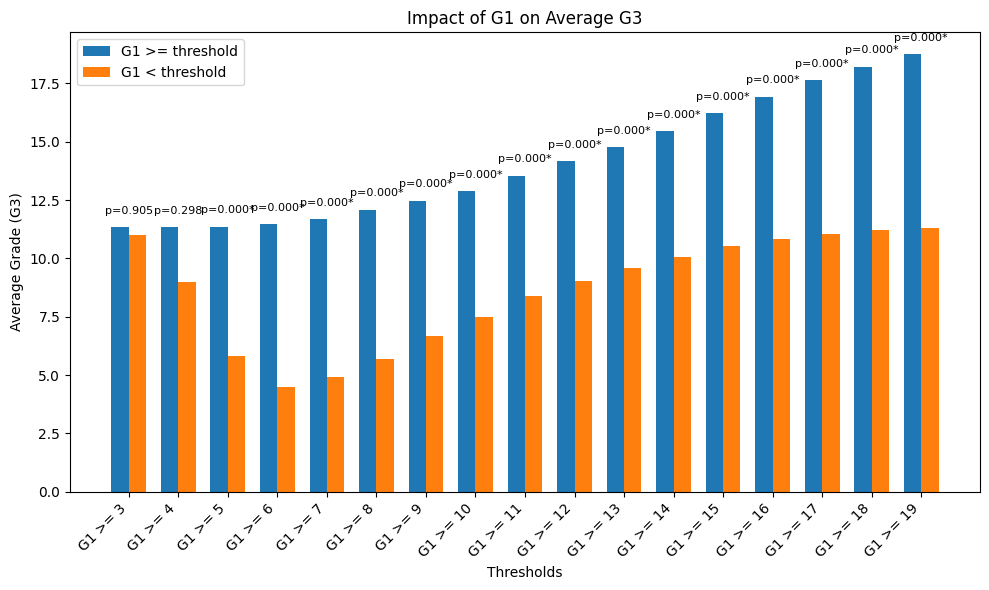

failures >= 1: 7.945652173913044 vs failures < 1: 12.046296296296296 (p-value: 4.130265743431049e-42, significant: True)
failures >= 2: 7.158730158730159 vs failures < 2: 11.592893401015228 (p-value: 3.1196576951486314e-19, significant: True)
failures >= 3: 6.8 vs failures < 3: 11.459724950884086 (p-value: 5.740213839727921e-11, significant: True)


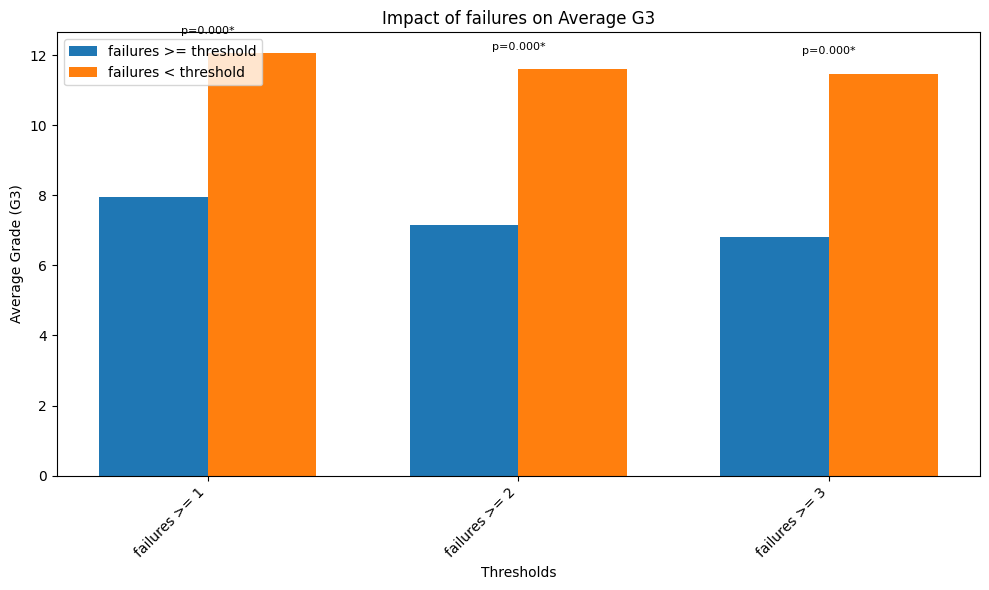

absences >= 1: 11.570596797671033 vs absences < 1: 10.861495844875346 (p-value: 0.004846899527787601, significant: True)
absences >= 2: 11.549107142857142 vs absences < 2: 10.928191489361701 (p-value: 0.012818964025034999, significant: True)
absences >= 3: 11.360160965794769 vs absences < 3: 11.295825771324864 (p-value: 0.7886498730257325, significant: False)
absences >= 4: 11.37136929460581 vs absences < 4: 11.287985865724382 (p-value: 0.7287573620865144, significant: False)
absences >= 5: 11.208955223880597 vs absences < 5: 11.38148667601683 (p-value: 0.5019364688287249, significant: False)
absences >= 6: 11.182389937106919 vs absences < 6: 11.389041095890411 (p-value: 0.42784831247504895, significant: False)
absences >= 7: 10.932489451476794 vs absences < 7: 11.441430332922318 (p-value: 0.07541919412899417, significant: False)
absences >= 8: 10.876651982378855 vs absences < 8: 11.450669914738125 (p-value: 0.048280221148860714, significant: True)
absences >= 9: 10.723926380368098 vs 

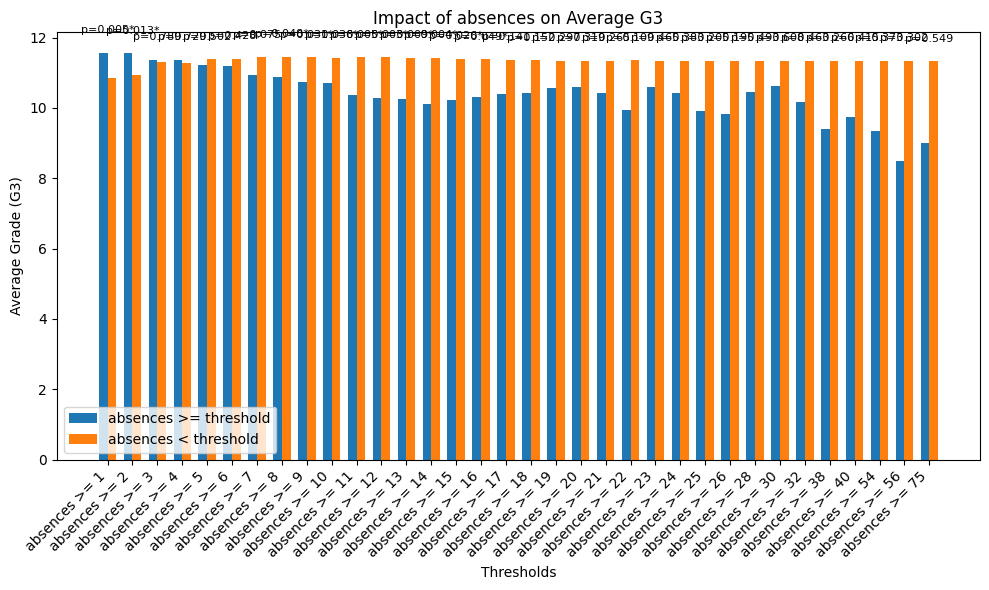

age >= 16: 11.230679156908666 vs age < 16: 11.74742268041237 (p-value: 0.09377506017878794, significant: False)
age >= 17: 11.02972027972028 vs age < 17: 11.682773109243698 (p-value: 0.006568288730090912, significant: True)
age >= 18: 10.528813559322034 vs age < 18: 11.638778220451528 (p-value: 2.880160423613298e-05, significant: True)
age >= 19: 9.267605633802816 vs age < 19: 11.475946775844422 (p-value: 3.2400923575869136e-06, significant: True)
age >= 20: 11.142857142857142 vs age < 20: 11.328820116054159 (p-value: 0.8586061287671809, significant: False)
age >= 21: 8.4 vs age < 21: 11.340364333652925 (p-value: 0.09068018868846027, significant: False)
age >= 22: 6.5 vs age < 22: 11.335564053537285 (p-value: 0.07801902785845481, significant: False)


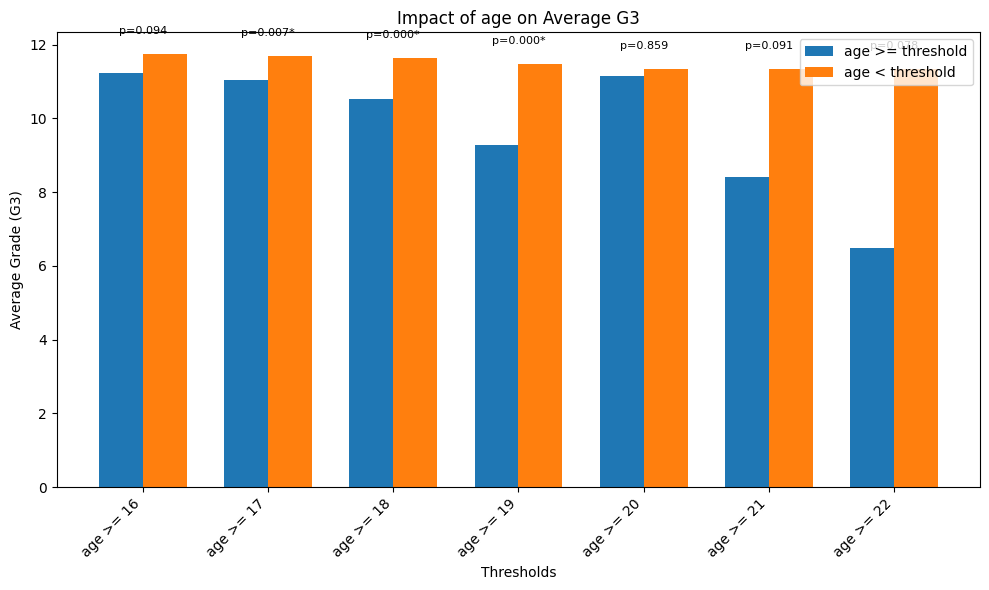

In [44]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Take the features where the average SHAP value is above the SHAP value threshold (0.05)
shap_values_avg_above_threshold = {key: value for key, value in shap_values_avg.items() if value["avg"] > 0.05}

# We will loop over all of the features above the threshold and see the impact
for feature in shap_values_avg_above_threshold.keys():
    # Find all values for the feature
    feature_values = sorted(data[feature].unique().tolist())

    # Initialize lists to store the thresholds, above average values, below average values and p-values for plotting later
    thresholds = []
    above_avg_values = []
    below_avg_values = []
    p_values = []

    # Loop over all these feature values, and calculate average G3 for above and below this feature
    # We skip the first value, because the filter would cause all values to belong to the same group
    for value in feature_values[1:]:
        above = data[data[feature] >= value]
        below = data[data[feature] < value]

        above_avg = above["G3"].mean()
        below_avg = below["G3"].mean()

        # Calculate if the difference is significant using scipy
        t, p = stats.ttest_ind(above["G3"], below["G3"])

        # Append results for plotting
        thresholds.append(value)
        above_avg_values.append(above_avg)
        below_avg_values.append(below_avg)
        p_values.append(p)

        print(f"{feature} >= {value}: {above_avg} vs {feature} < {value}: {below_avg} (p-value: {p}, significant: {p < 0.05})")

    # Create the bar chart for the current feature
    x = np.arange(len(thresholds))  # X-axis positions
    width = 0.35  # Width of bars

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, above_avg_values, width, label=f"{feature} >= threshold")
    ax.bar(x + width / 2, below_avg_values, width, label=f"{feature} < threshold")

    # Add labels, title, and legend
    ax.set_xlabel("Thresholds")
    ax.set_ylabel("Average Grade (G3)")
    ax.set_title(f"Impact of {feature} on Average G3")
    ax.set_xticks(x)
    ax.set_xticklabels([f"{feature} >= {thresh}" for thresh in thresholds], rotation=45, ha="right")
    ax.legend()

    # Add p-value annotations
    for i, p in enumerate(p_values):
        significance = "*" if p < 0.05 else ""
        ax.text(
            x[i],
            max(above_avg_values[i], below_avg_values[i]) + 0.5,
            f"p={p:.3f}{significance}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # Show the plot
    plt.tight_layout()
    plt.show()
